In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as scop
from scipy.optimize import curve_fit
import csv
import matplotlib as mpl
import os
import inspect


#LOADING FUNCTION
def load_data(file_location, file_name, Dimension=1):
    """
    Load a csv file from SSNake analysed dataset

    Parameters
    ----------
    file_location : str
        Directory where the data file is stored.
    file_name : str
        Name of the data file.
    Dimension : int, optional
        Dimension of the data (1D or 2D). Default is 1.

    Returns
    -------
    df : pd.DataFrame
        dataframe containing the data.
    
    """
    FILEANDPATH = file_location+file_name

    # Find where headers start 
    index_of_headers = 0
    for i in range(100):
        try:
            _ = pd.read_csv(FILEANDPATH, sep=",", skiprows=i, encoding="unicode_escape")
            index_of_headers = i + 1  # need +1 for correct parsing
            break
        except Exception:
            continue

    # Load dataframe properly
    df_raw = pd.read_csv(FILEANDPATH, sep=",", skiprows=index_of_headers, encoding="unicode_escape")

    
    
    return df_raw, index_of_headers

#SAVE PLOT FUNCTION


import matplotlib.pyplot as plt

def save_next_plot(save_folder, prefix="graph", ext="png", fig=None):
    """
    Save the current matplotlib figure into 'folder' with auto-increment filename.
    
    Parameters
    ----------
    save_folder : str
        Path to the folder where plots will be saved.
    prefix : str, default 'graph'
        Filename prefix, e.g. 'graph' -> graph_001.png
    ext : str, default 'png'
        File extension, e.g. 'png', 'pdf', 'svg'.
    fig : matplotlib.figure.Figure, optional
        Figure to save. Defaults to current figure.
        
    Returns
    -------
    str
        Full path of the saved file.
    """
    os.makedirs(save_folder, exist_ok=True)
    
    # Find the last numbered file
    existing = [f for f in os.listdir(save_folder) if f.startswith(prefix) and f.endswith(f".{ext}")]
    numbers = [int(f.replace(prefix + "_", "").replace(f".{ext}", "")) for f in existing if f[0].isdigit()]
    
    # Determine next file number
    next_num = max(numbers) + 1 if numbers else 1
    filename = f"{prefix}_{next_num:03d}.{ext}"
    fullpath = os.path.join(save_folder, filename)
    
    # Use the provided figure or the current one
    if fig is None:
        fig = plt.gcf()
    
    # Save the figure
    fig.savefig(fullpath, dpi=300, bbox_inches="tight")
    print(f"Plot saved as: {fullpath}")
    
    # Close the figure after saving it (important for interactive sessions)
    plt.close(fig)
    
    return fullpath




# PLOTTING FUNCTIONS

def T1_model(t, M0, A, T1):
    return M0 * (1 - A * np.exp(-t / T1))

T1_model.equation = r"$M(t)=M_0(1 - A e^{-t/T_1})$"

def T1_3over2_model(t, M0, T1):
    return M0 * (1 - 0.1 * np.exp(-t / T1) - 0.9 * np.exp(-6 * t / T1))

T1_3over2_model.equation = r"$M(t)=M_0[1 - 0.1 e^{-t/T_1} - 0.9 e^{-6t/T_1}]$"




import numpy as np
from scipy.optimize import curve_fit

def plot_data(df, x_col, y_col, title, x_label="x", y_label="y",
              ylimits=None, xlimits=None,
              title_fs=24, label_fs=20, tick_fs=18, legend_fs=18,
              fit_T1_curve=True, model=T1_model):

    if isinstance(x_col, int):
        x_col = df.columns[x_col]
    if isinstance(y_col, int):
        y_col = df.columns[y_col]

    x = np.array(df[x_col], dtype=float)
    y = np.array(df[y_col], dtype=float)

    plt.figure(figsize=(18, 10))

    # scatter
    plt.scatter(x, y, s=10, facecolors='none', edgecolors='b', label='Data')

    if fit_T1_curve:

        # Initial guess: M0, A (set to 0.73), T1
        p0 = (
            np.max(y),        # M0: correct scale
            0.73,             # A: initial guess set to 0.73
            0.3 * np.max(x)   # T1: fraction of time window
        )

        # Bounds for the fitting parameters
        bounds = (
            [np.min(y), 0.68, 0],  # Lower bounds for M0, A, and T1
            [np.max(y), 0.78, np.max(x)]  # Upper bounds for M0, A, and T1
        )

        # Fit the model using curve_fit with bounds
        popt, pcov = curve_fit(model, x, y, p0=p0, bounds=bounds)

        # Generate fitted curve for plotting
        t_fit = np.linspace(0, max(x), 500)
        y_fit = model(t_fit, *popt)

        # formatted parameters:
        param_str = ",\; ".join(
            [f"{name}={val:.3g}" for name, val in zip(list(model.__code__.co_varnames)[1:], popt)]
        )

        # dynamically read model's equation
        eqn_label = model.equation + "\n" + rf"$ {param_str} $"

        # Plot the fitted curve
        plt.plot(t_fit, y_fit, linewidth=3, label=eqn_label)

    # labels
    plt.title(title, fontsize=title_fs)
    plt.xlabel(x_label, fontsize=label_fs)
    plt.ylabel(y_label, fontsize=label_fs)
    plt.xlim(xlimits)
    plt.xscale('log')
    plt.ylim(ylimits)
    plt.grid(True)
    plt.xticks(fontsize=tick_fs)
    plt.yticks(fontsize=tick_fs)
    plt.legend(fontsize=legend_fs)
    plt.show()

    if fit_T1_curve:
        return popt, pcov



In [65]:
#df,_ = load_data("C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/NMR_NQR/RuCl3_NQR_November_2025/Processed/","855_T1.csv")
#df,_ = load_data("C:/Users/thoma/Documents/Python Scripts/strain-cell/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/NMR_NQR/RuCl3_NQR_November_2025/Processed//"

# initial T1 files measured November 2025
# First_T1_files = ["855_T1.csv", "857_T1.csv", "859_T1.csv", "861_T1.csv", "863_T1.csv", "867_T1.csv", "869_T1.csv"]

#second set of T1 files measured December 2025 
T1_files = ["894_T1.csv", "898_T1.csv", "903_T1.csv", "905_T1.csv", "907_T1.csv", "867_T1.csv", "869_T1.csv"]
#Excluding the 20K value 
#T1_files = ["894_T1.csv", "903_T1.csv", "905_T1.csv", "907_T1.csv", "867_T1.csv", "869_T1.csv"]

dfs = []  # list to hold all dataframes

for n in range(len(T1_files)):
    #Uni: 
    # df,_ = load_data("C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/NMR_NQR/RuCl3_NQR_November_2025/Processed/",T1_files[n])

    #Laptop:
    df,_ = load_data("C:/Users/thoma/Documents/Physics_Work/Python Scripts/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/NMR_NQR/RuCl3_NQR_November_2025/Processed/",T1_files[n])
    
    dfs.append(df)

#Normalisation procedure 

# Define number of averages for each file
averages = [6e4, 6e4, 6e4, 6e4, 6e4, 4e4, 4e4]  # Replace with values
#Excluding the 20K value 
#averages = [6e4, 6e4, 6e4, 6e4, 4e4, 4e4]


# Divide by averages
for i, df in enumerate(dfs):
    df.iloc[:, 1] = df.iloc[:, 1] / averages[i]

#Multiply by temperature

#Second temperatures measured December 2025
temperature = np.array([7.5, 20, 8.5, 9.5, 10.5, 9,8])
#Excluding the 20K value 
#temperature = np.array([7.5, 8.5, 9.5, 10.5, 9,8])

for i, df in enumerate(dfs):
    df.iloc[:, 1] = df.iloc[:, 1]*temperature[i]

# Find global max y after dividing 
#This only works if all Tau's are the same (note all in dec '25 set are same tau except 20K which was at 100us, not 150us like the rest)

y_col = 1
global_max = max(df.iloc[:, y_col].max() for df in dfs)

# Normalize to global max
for df in dfs:
    df.iloc[:, y_col] = df.iloc[:, y_col] / global_max

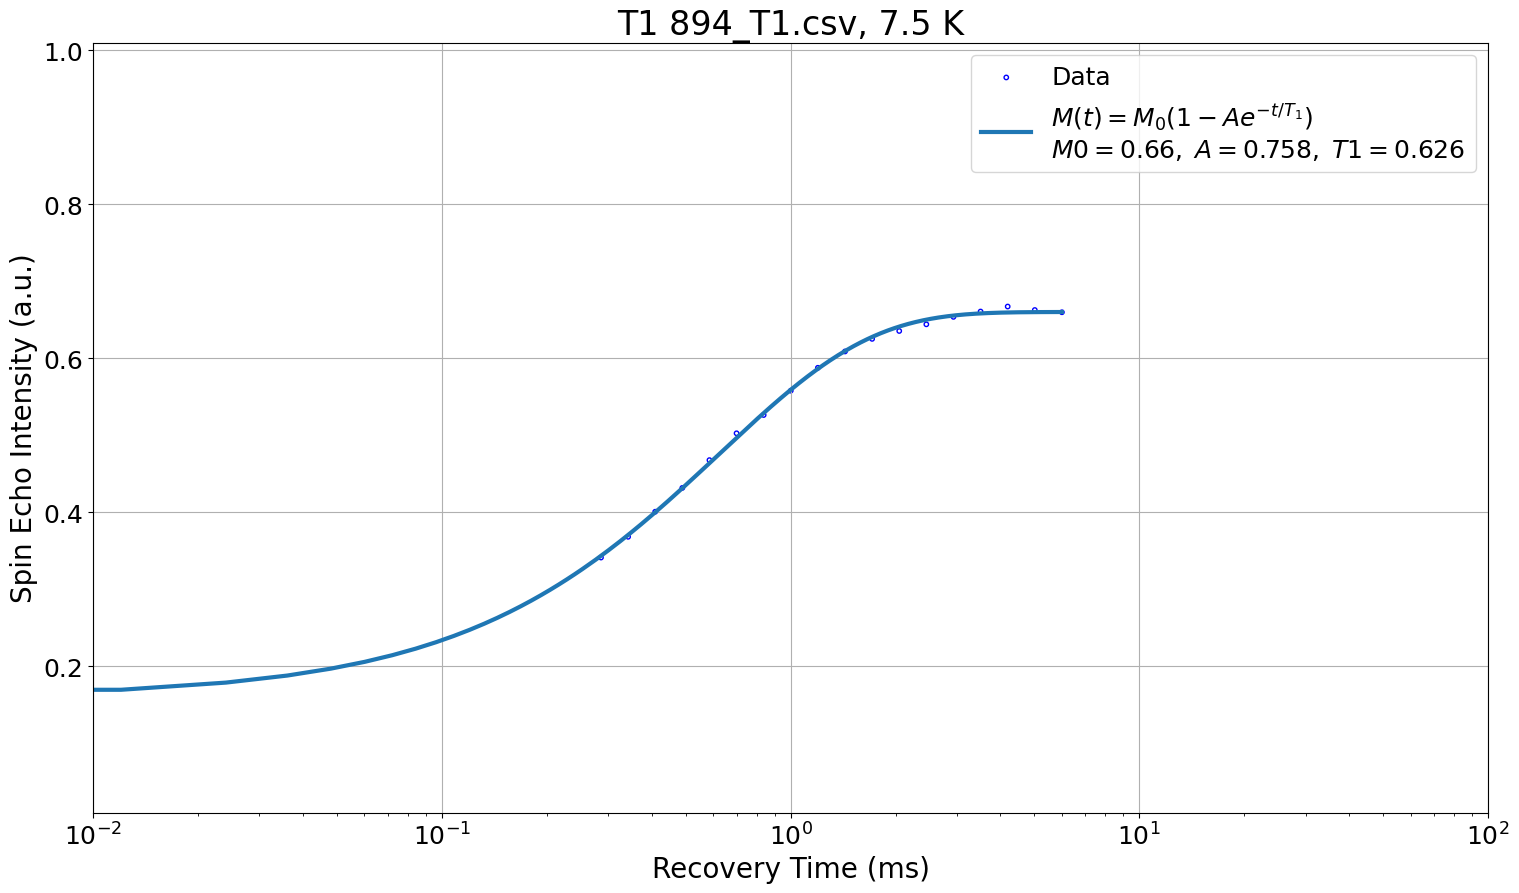

0 [[ 2.65224621e-06 -6.29925616e-06  1.39118134e-05]
 [-6.29925616e-06  1.27062133e-04 -1.33912051e-04]
 [ 1.39118134e-05 -1.33912051e-04  1.84763949e-04]]


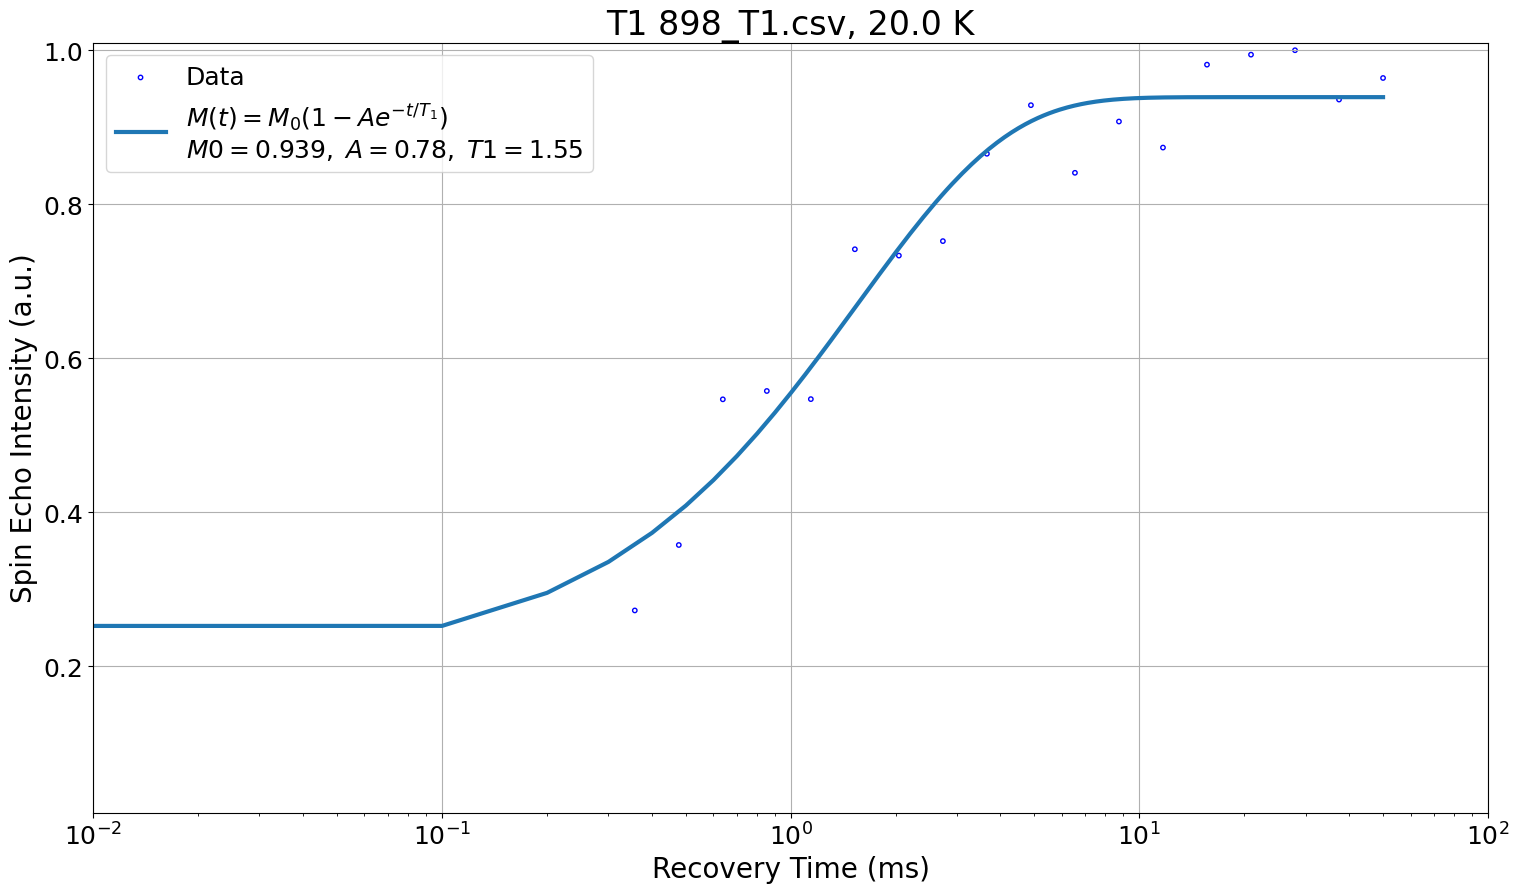

1 [[ 0.00043572 -0.00025276  0.00291327]
 [-0.00025276  0.00535581 -0.0165239 ]
 [ 0.00291327 -0.0165239   0.08136523]]


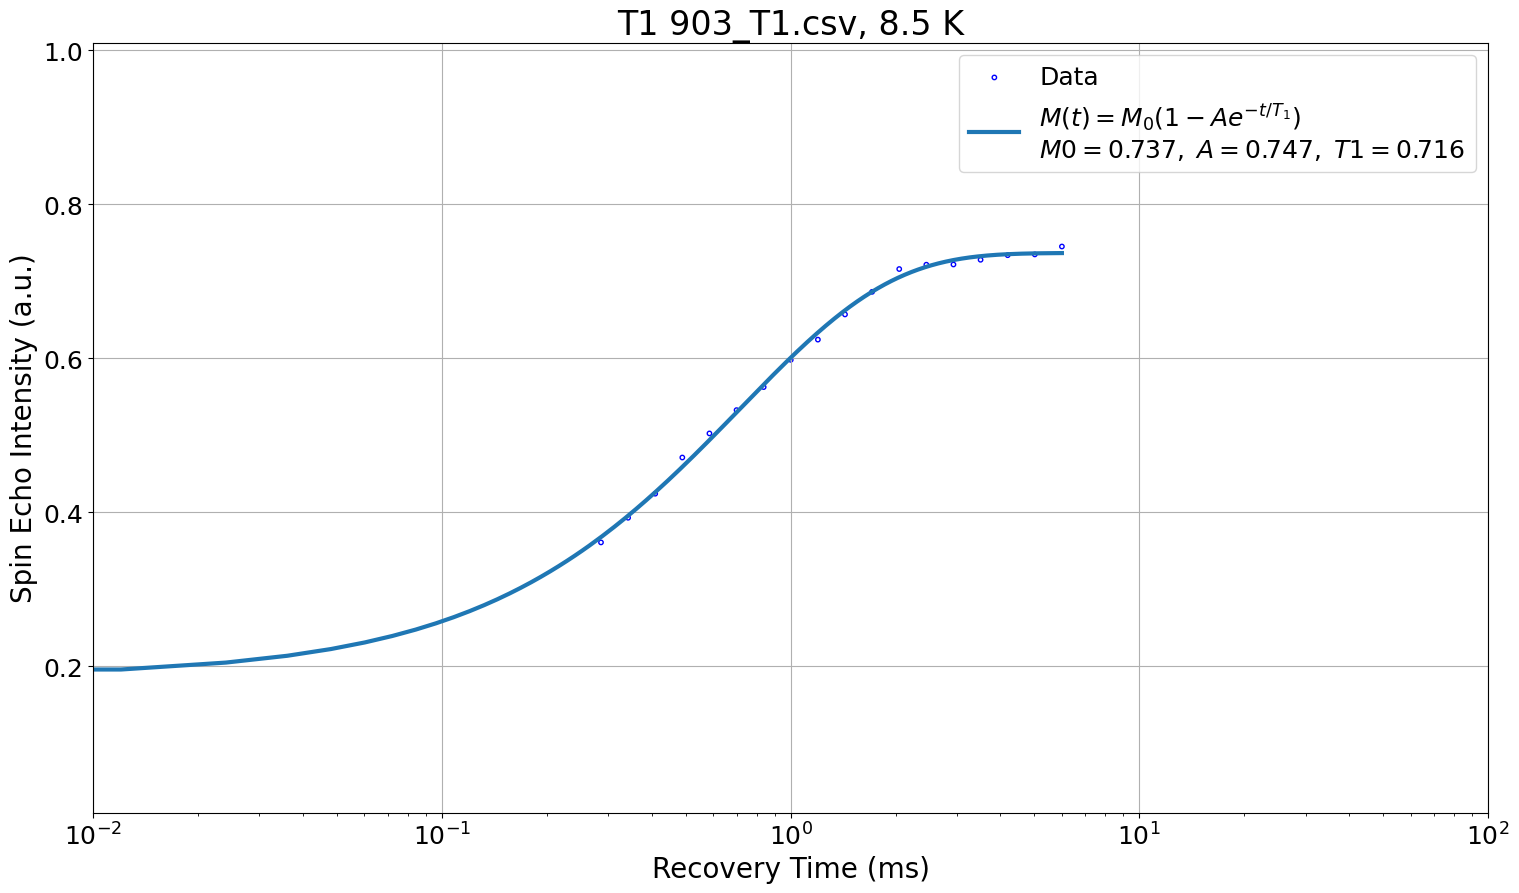

2 [[ 9.01561713e-06 -1.54098002e-05  4.60418723e-05]
 [-1.54098002e-05  2.26120807e-04 -3.00168409e-04]
 [ 4.60418723e-05 -3.00168409e-04  5.46019629e-04]]


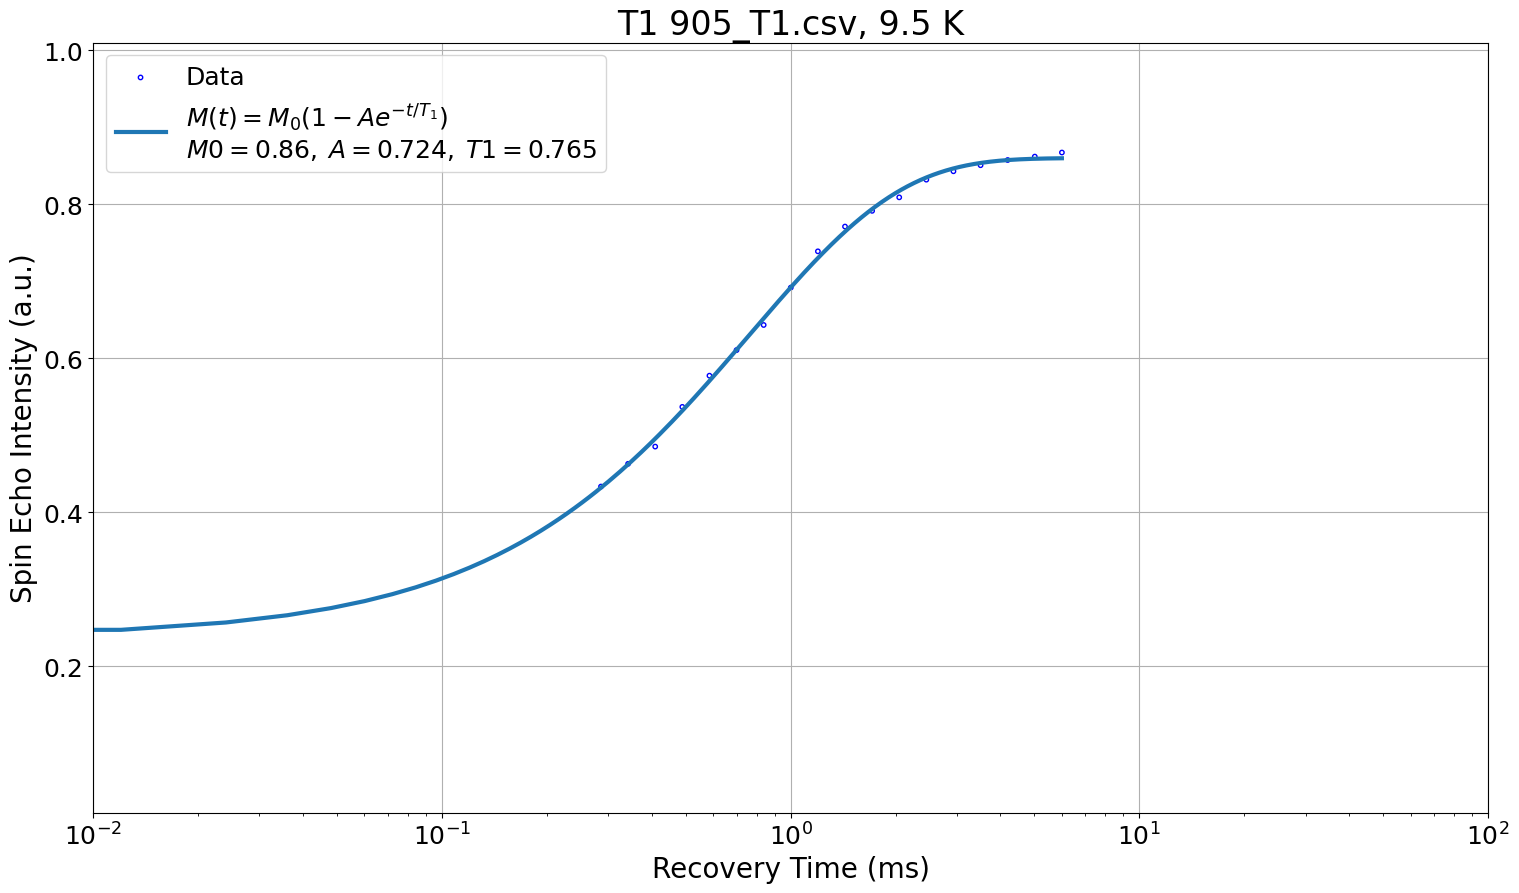

3 [[ 7.78880826e-06 -1.01028345e-05  3.64254003e-05]
 [-1.01028345e-05  1.16457713e-04 -1.76850677e-04]
 [ 3.64254003e-05 -1.76850677e-04  3.79059292e-04]]


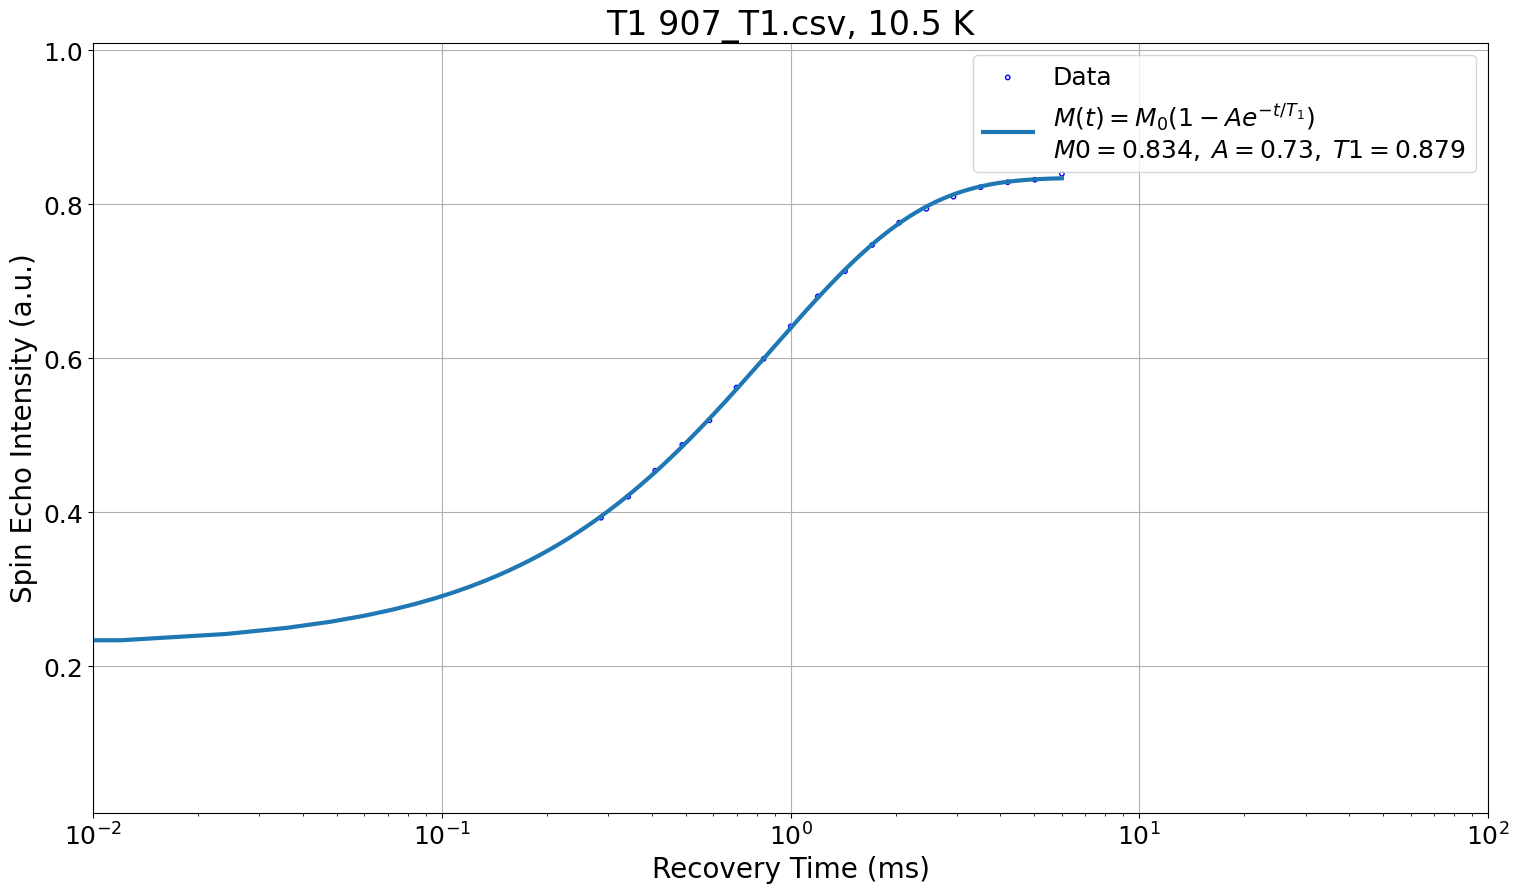

4 [[ 1.45276157e-06 -1.56927182e-06  7.52450297e-06]
 [-1.56927182e-06  1.49500547e-05 -2.81367321e-05]
 [ 7.52450297e-06 -2.81367321e-05  7.90091363e-05]]


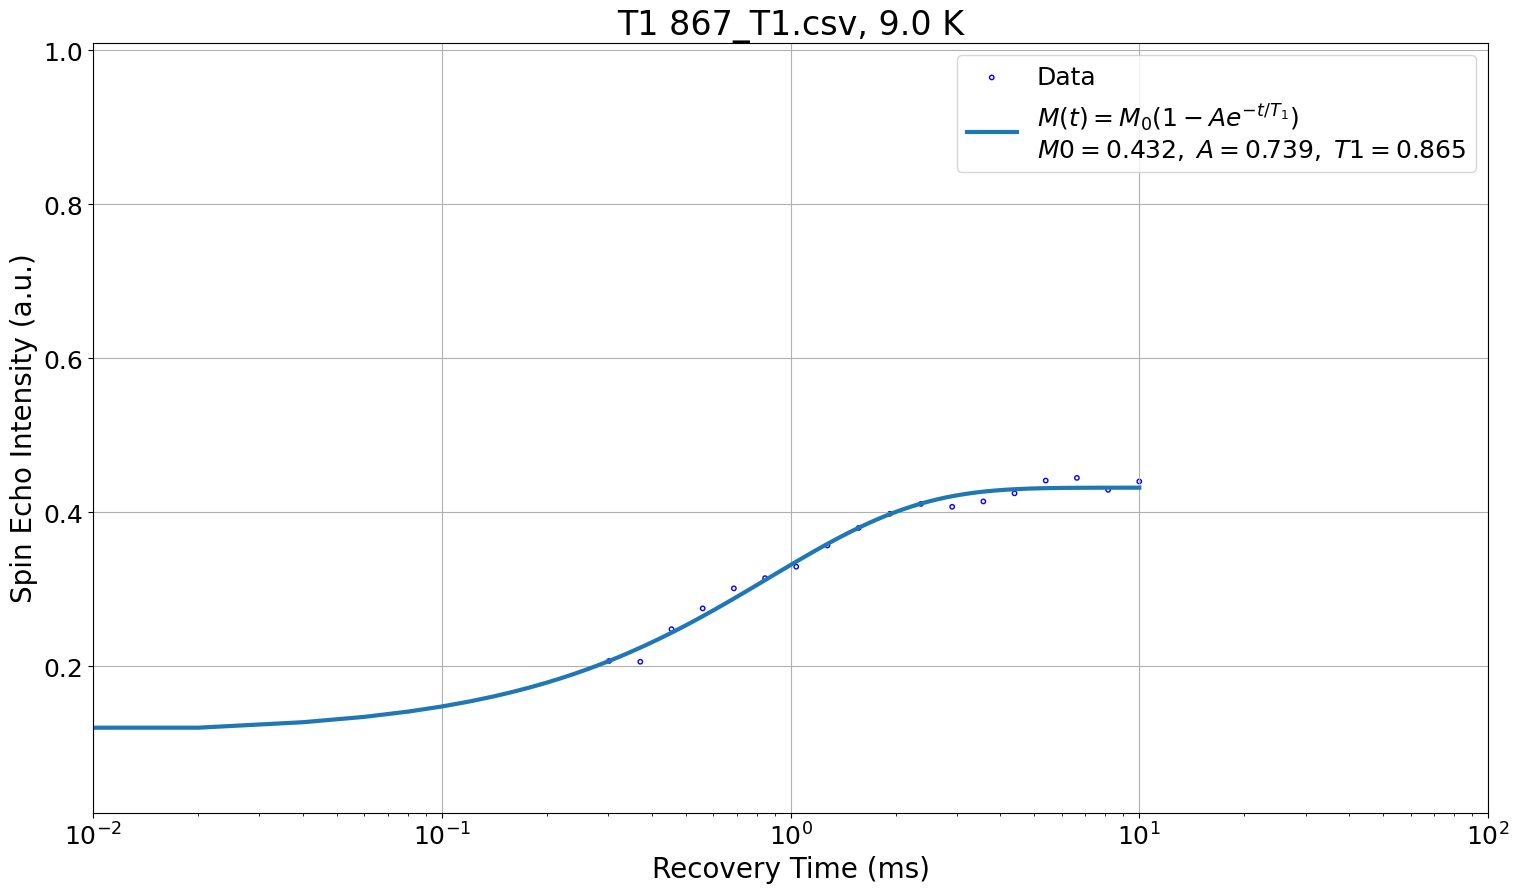

5 [[ 1.54974540e-05 -3.58375403e-05  1.54702477e-04]
 [-3.58375403e-05  1.10979419e-03 -1.83349135e-03]
 [ 1.54702477e-04 -1.83349135e-03  4.31805040e-03]]


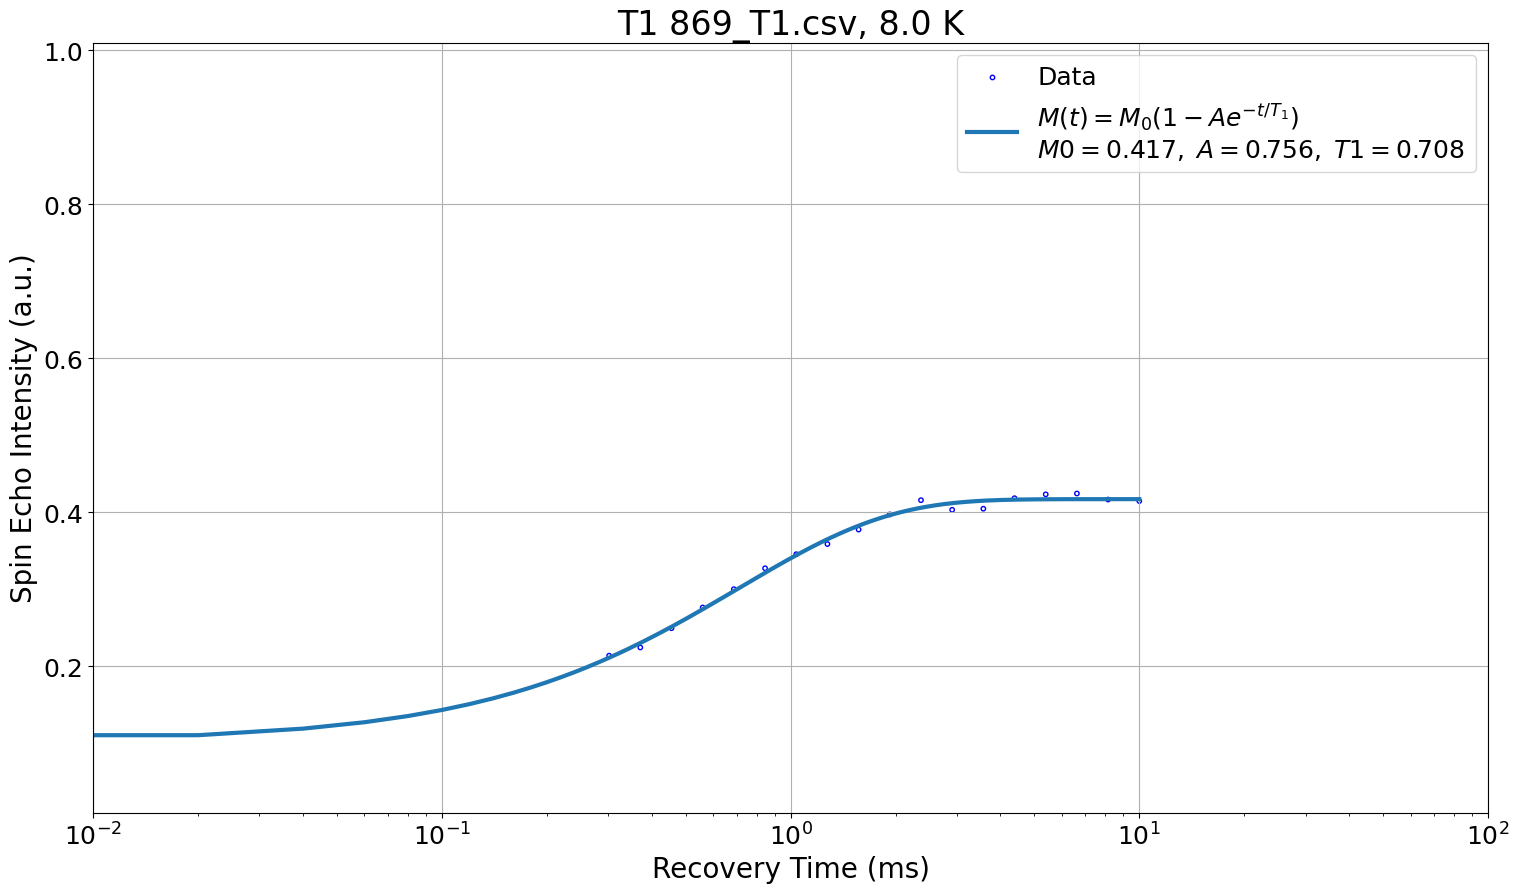

6 [[ 5.24156927e-06 -1.73266460e-05  4.73706916e-05]
 [-1.73266460e-05  7.05171697e-04 -8.42400828e-04]
 [ 4.73706916e-05 -8.42400828e-04  1.33703185e-03]]


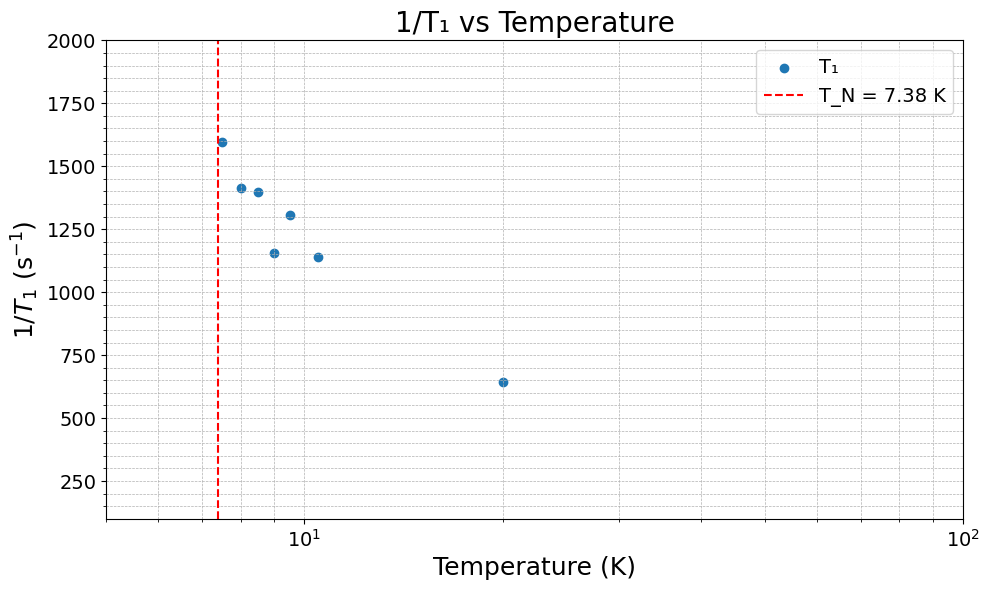

In [66]:
# --- Extract T1 values ---

T1_values = []

# --- Define temperature array 

#first temperatures measured November 2025
#temperature = np.array([10, 14, 18, 22, 26, 9,8])

#Second temperatures measured December 2025
temperature = np.array([7.5, 20, 8.5, 9.5, 10.5, 9,8])

#Excluding the 20K value 
#temperature = np.array([7.5, 8.5, 9.5, 10.5, 9,8])

#SAVING PLOT TOGGLE
save_next_plot_active_T1 = True
#Uni:
# save_folder = "C:
#Laptop:
save_folder = "C:/Users/thoma/Documents/Physics_Work/Python Scripts/strain-cell/Plotted Figures/NQR/"

for i, df in enumerate(dfs):
    popt, pcov = plot_data(
        df, 0, 1,
        f"T1 {T1_files[i]}, {temperature[i]} K",
        x_label="Recovery Time (ms)",
        y_label="Spin Echo Intensity (a.u.)",
        model=T1_model,
        xlimits=(0.01, 100),
        ylimits=(0.01, 1.01)
    )
    print(f"{i} {pcov}")
   
    if popt is not None:
        T1_values.append(popt[-1])

plt.close('all')

# Make sure T1_values is a NumPy array
T1_values = np.array(T1_values)

# Convert from ms → s
T1_s = T1_values * 1e-3

# Compute 1/T1 in s^-1
inv_T1 = 1 / T1_s



# --- Plot 1/T1 vs Temperature ---

plt.figure(figsize=(10, 6))
plt.scatter(temperature, inv_T1, marker='o', linestyle='-', label='T₁')

plt.xlabel("Temperature (K)", fontsize=18)
plt.ylabel(r"$1/T_1$ (s$^{-1}$)", fontsize=18)
plt.title("1/T₁ vs Temperature", fontsize=20)

plt.xscale('log')
#plt.yscale('log')
plt.xlim(5,100)
plt.ylim(1e2,2e3)
plt.vlines(x=7.38,ymin=1e2,ymax=1e10, color='r', linestyle='--', label='T_N = 7.38 K')
# Major ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Enable minor ticks
plt.minorticks_on()

# Grid on both major and minor ticks
plt.grid(which='both', linestyle='--', linewidth=0.5)

plt.grid(True)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()
#SAVING PLOT TOGGLE
save_next_plot_active_invT1s = False




Fitted parameters: A = 1.277e+03, Tc = 7.38 (fixed), alpha = 0.139


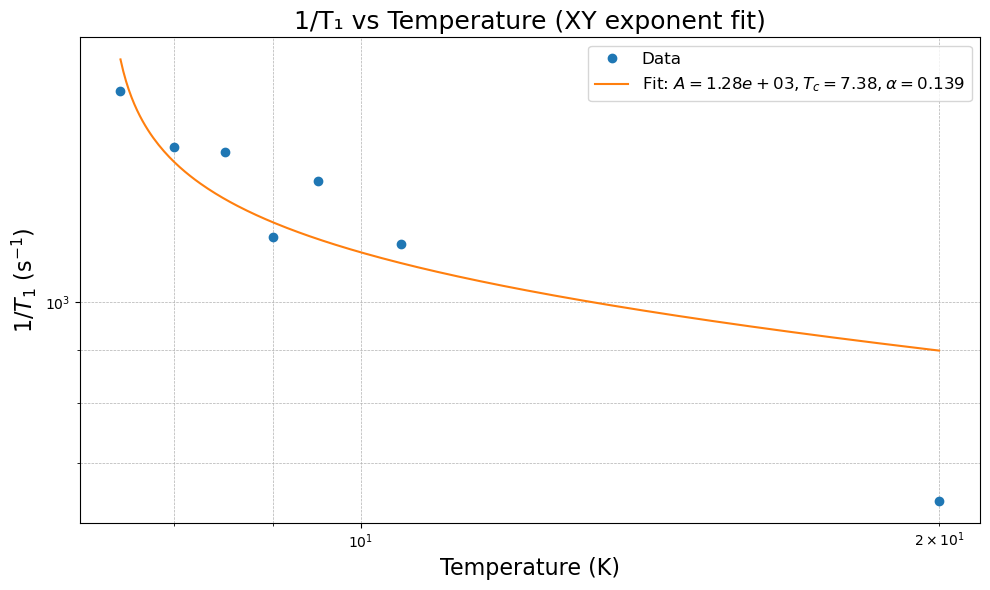

In [67]:
#fit the exponential behaviour using BKT

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# 1/T1 conversion
T1_values = np.array(T1_values)
T1_s = T1_values * 1e-3
inv_T1 = 1 / T1_s

#first temperatures measured November 2025
#temperature = np.array([10, 14, 18, 22, 26, 9,8])

#Second temperatures measured December 2025
temperature = np.array([7.5, 20, 8.5, 9.5, 10.5, 9,8])



# XY exponent function with Tc fixed
Tc_fixed = 7.38  # K
def XY_exponent_fixedTc(T, A, alpha):
    return A * (T - Tc_fixed)**(-alpha)

# Fit only T > Tc
mask = temperature > Tc_fixed
T_fit = temperature[mask]
inv_T1_fit = inv_T1[mask]

# Initial guess
p0 = [1e-2, 0.5]  # A, alpha

# Fit
popt, pcov = curve_fit(XY_exponent_fixedTc, T_fit, inv_T1_fit, p0=p0)
A_fit, alpha_fit = popt

print(f"Fitted parameters: A = {A_fit:.3e}, Tc = {Tc_fixed:.2f} (fixed), alpha = {alpha_fit:.3f}")

# --- Plot data + fit with legend showing fit values ---
T_plot = np.linspace(min(T_fit), max(T_fit), 500)
plt.figure(figsize=(10,6))
plt.plot(temperature, inv_T1, 'o', label='Data')

# Include fit parameters in legend
fit_label = rf'Fit: $A={A_fit:.2e}, T_c={Tc_fixed:.2f}, \alpha={alpha_fit:.3f}$'
plt.plot(T_plot, XY_exponent_fixedTc(T_plot, *popt), '-', label=fit_label)

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Temperature (K)", fontsize=16)
plt.ylabel(r"$1/T_1$ (s$^{-1}$)", fontsize=16)
plt.title("1/T₁ vs Temperature (XY exponent fit)", fontsize=18)
plt.grid(which='both', ls='--', lw=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
